In [1]:
import pandas as pd
import numpy as np
import re

from bokeh.plotting import figure, show
from bokeh.tile_providers import get_provider, STAMEN_TONER, CARTODBPOSITRON_RETINA
from bokeh.models import HoverTool, FreehandDrawTool, BoxEditTool, ColumnDataSource

### For some reason bokeh maps uses Web Mercator coordinates
* Define function to switch from lat/long to mercator x/y coordinates

In [35]:
# Define function to switch from lat/long to mercator x/y coordinates
def to_mercator(lat, lon):
    
    r_major = 6378137.000
    x = r_major * np.radians(lon)
    scale = x/lon
    y = 180.0/np.pi * np.log(np.tan(np.pi/4.0 + 
        lat * (np.pi/180.0)/2.0)) * scale
    return (x, y)

#### Ames, Iowa latitude-longitude (42.034534, -93.620369), converted to mercator

In [3]:
# Ames, Iowa lat long, converted to mercator
Ames_center = to_mercator(42.034534, -93.620369)

In [4]:
geo = pd.read_csv('geodata.csv')
geo.shape

(2624, 2)

In [5]:
geo.head()

,PID,lat_long
0,909176150,"(42.01856448979592, -93.65161918367347)"
1,905476230,"(42.024855315930424, -93.66367099341755)"
2,905476230,"(42.024855315930424, -93.66367099341755)"
3,911128020,"(42.021547615297024, -93.61406809992513)"
4,535377150,"(42.03739146938776, -93.61220695918368)"


#### Convert all house lat_long to mercator coordinates

In [6]:
#list of house mercator coordinates
x_merc = []
y_merc = []

for each in geo['lat_long']:
    ll = re.sub("[^0-9.\- ]","",each).split()
    #if 0, append center of Ames (-10421771.804958373, 5166153.874296733)
    if ll == ['0']:
        x_merc.append(Ames_center[0])
        y_merc.append(Ames_center[1])
    else:
        x, y = to_mercator(float(ll[0]),float(ll[1]))
        x_merc.append(x)
        y_merc.append(y)

In [7]:
geo = pd.concat([geo, pd.Series(x_merc), pd.Series(y_merc)],axis=1).set_index('PID')

In [8]:
geo = geo.rename(columns={0:'x_merc',1:'y_merc'})

#### Create list of landmarks in Ames

In [36]:
landmarks = {'landmarks':['Iowa State University',
                          'Municipal Airport',
                          'North Grand Mall',
                          'Mary Greeley Medical Center',
                          'Jack Trice Stadium'],
            'x_merc':[to_mercator(42.0267,-93.6465)[0],
                      to_mercator(41.9987,-93.6223)[0],
                      to_mercator(42.0494,-93.6224)[0],
                      to_mercator(42.0323,-93.6111)[0],
                      to_mercator(42.0140,-93.6359)[0]],
            'y_merc':[to_mercator(42.0267,-93.6465)[1],
                      to_mercator(41.9987,-93.6223)[1],
                      to_mercator(42.0494,-93.6224)[1],
                      to_mercator(42.0323,-93.6111)[1],
                      to_mercator(42.0140,-93.6359)[1]]}

marks = pd.DataFrame(landmarks)

### Draw Map of Houses and Landmarks

In [10]:
background = get_provider(CARTODBPOSITRON_RETINA) #CARTODBPOSITRON_RETINA, STAMEN_TONER
x_zoom = 7000
y_zoom = 5000

# Base Map Layer
fig = figure(plot_width=1200, plot_height=800,
             x_range=(Ames_center[0]-x_zoom, Ames_center[0]+y_zoom), 
             y_range=(Ames_center[1]-x_zoom, Ames_center[1]+y_zoom),
             x_axis_type="mercator", y_axis_type="mercator",
             title="Ames Iowa Housing Map")
fig.add_tile(background)

# Dots for Houses
fig.circle(x="x_merc", y="y_merc",
         size=4,
         fill_color="orange", line_color='dodgerblue',
         fill_alpha=0.6,
         source=geo)

# Big Dots for Landmarks, with Hover interactivity
my_hover = HoverTool(names=['landmark'])
my_hover.tooltips = [('X', '@landmarks')]
fig.circle(x="x_merc", y="y_merc",
           size=10,
           fill_color="tomato", line_color='tomato',
           fill_alpha=0.3,
           name='landmark',
           source=marks)
fig.add_tools(my_hover)

# # Boxes
# sectordata = ColumnDataSource(
#     data={'x': [], 'y': [], 'width': [], 'height': []})

# mybox = fig.rect('x', 'y', 'width', 'height', color='pink', source=sectordata, alpha=0.4)
# boxes = BoxEditTool(renderers=[mybox],num_objects=5)
# fig.add_tools(boxes)

# Add draw tool
renderer = fig.multi_line([[1, 9]], [[5, 5]], line_width=4, alpha=0.4, color='red')
draw_tool = FreehandDrawTool(renderers=[renderer], num_objects=4)
fig.add_tools(draw_tool)

show(fig)

![citymap](Ames.png)

### Since data has neighborhood information, recode neighborhoods to bigger city "sectors"
* as per  https://www.thinkames.com/maps/

In [11]:
data = pd.read_csv('ALL_data.csv', index_col='PID')
data.shape

(2579, 81)

In [12]:
temp = data.Neighborhood.to_frame().copy()

#### Create recoding dictionary

In [13]:
code = {'Blmngtn': 'NO', 'Blueste':'SW', 'BrDale': 'NO',
        'BrkSide':'DT', 'ClearCr': 'SW', 'CollgCr':'SW',
        'Crawfor':'SW', 'Edwards':'SW', 'Gilbert': 'NO',
        'IDOTRR':'DT', 'MeadowV':'SE', 'Mitchel':'SE',
        'NAmes':'NO', 'NoRidge':'NW', 'NPkVill':'NO',
        'NridgHt':'NW', 'NWAmes':'NO', 'OldTown':'DT',
        'SWISU':'SW', 'Sawyer':'NW', 'SawyerW':'NW',
        'Somerst':'NW', 'StoneBr':'NO', 'Timber':'SW',
        'Veenker':'NW', 'Greens':'NW', 'GrnHill':'SW', 'Landmrk':'DT'}

# NW            NorthWest
# NO            North
# NE            NorthEast (No Houses)
# SW            SoutWest
# DT            Downtown
# SO            South     (No Houses)
# SE            SouthEast

* Create new Column with House Sector Data

In [14]:
temp['Sector'] = [code[each] for each in temp.Neighborhood]

In [15]:
temp.Sector.value_counts()

NO    793
SW    641
NW    614
DT    393
SE    138
Name: Sector, dtype: int64

In [16]:
assert temp.Sector.value_counts().agg('sum') == temp.Neighborhood.count() == 2579, "Check Counts!"

In [17]:
# Set Sector Colors for Map
color_dict = {'NO':'green',
              'SW':'purple',
              'NW':'yellow',
              'DT':'dodgerblue',
              'SE':'red',
              'SO':'black'}
temp['Color'] = [color_dict[each] for each in temp.Sector]

#### Join to geo DF

In [18]:
map_data1 = geo.merge(temp,how='left',on='PID')

### Map again with Sector Colors

In [19]:
background = get_provider(CARTODBPOSITRON_RETINA) #CARTODBPOSITRON_RETINA, STAMEN_TONER
x_zoom = 7000
y_zoom = 5000

# Base Map Layer
fig = figure(plot_width=1200, plot_height=800,
             x_range=(Ames_center[0]-x_zoom, Ames_center[0]+y_zoom), 
             y_range=(Ames_center[1]-x_zoom, Ames_center[1]+y_zoom),
             x_axis_type="mercator", y_axis_type="mercator",
             title="Ames Iowa Housing Map")
fig.add_tile(background)

# Dots for Houses
my_hover = HoverTool(names=['House'])
my_hover.tooltips = [('PID', '@Neighborhood')]
fig.circle(x="x_merc", y="y_merc",
           size=5,
           color='Color', line_color='black', line_width = 0.5,
           fill_alpha=0.6,
           name='House',
           source=map_data1)
fig.add_tools(my_hover)

# Big Dots for Landmarks, with Hover interactivity
my_hover = HoverTool(names=['landmark'])
my_hover.tooltips = [('X', '@landmarks')]
fig.circle(x="x_merc", y="y_merc",
           size=10,
           fill_color="tomato", line_color='tomato',
           fill_alpha=0.3,
           name='landmark',
           source=marks)
fig.add_tools(my_hover)


# Add draw tool
renderer = fig.multi_line([[1, 9]], [[5, 5]], line_width=4, alpha=0.4, color='red')
draw_tool = FreehandDrawTool(renderers=[renderer], num_objects=4)
fig.add_tools(draw_tool)

show(fig)

In [20]:
anal_1 = data.merge(map_data1['Sector'], how='left', on='PID')
anal_1.drop_duplicates(inplace=True)

#### Compare the prices of different sectors

In [21]:
anal_1.groupby('Sector')['SalePrice'].agg(['mean','std']).sort_values(by='mean', ascending=False)

,mean,std
Sector,,
NW,228355.210098,94494.859699
SW,181907.879875,63577.687234
NO,168734.272383,56512.411747
SE,146439.057971,46025.290063
DT,123083.740458,41681.521694


# Regroup the Sectors

![citymap](Recode.png)

In [22]:
code = {'Blmngtn': 'NO', 'Blueste':'SO', 'BrDale': 'NO',
        'BrkSide':'DT', 'ClearCr': 'WE', 'CollgCr':'WE',
        'Crawfor':'SO', 'Edwards':'WE', 'Gilbert': 'NO',
        'IDOTRR':'DT', 'MeadowV':'SE', 'Mitchel':'SE',
        'NAmes':'NO', 'NoRidge':'NO', 'NPkVill':'NO',
        'NridgHt':'NO', 'NWAmes':'NO', 'OldTown':'DT',
        'SWISU':'SO', 'Sawyer':'WE', 'SawyerW':'WE',
        'Somerst':'NO', 'StoneBr':'NO', 'Timber':'SO',
        'Veenker':'NO', 'Greens':'NO', 'GrnHill':'SO', 'Landmrk':'DT'}

# NO            North
# WE            West
# SO            South
# DT            Downtown
# SE            SouthEast

In [23]:
temp['Sector'] = [code[each] for each in temp.Neighborhood]
temp.Sector.value_counts()

NO    1155
WE     693
DT     393
SO     200
SE     138
Name: Sector, dtype: int64

In [24]:
assert temp.Sector.value_counts().agg('sum') == temp.Neighborhood.count() == 2579, "Check Counts!"

In [25]:
# Set Sector Colors for Map
color_dict = {'NO':'green',
              'WE':'purple',
              'DT':'dodgerblue',
              'SE':'red',
              'SO':'orange'}
temp['Color'] = [color_dict[each] for each in temp.Sector]

In [26]:
map_data2 = geo.merge(temp,how='left',on='PID')

In [27]:
background = get_provider(CARTODBPOSITRON_RETINA) #CARTODBPOSITRON_RETINA, STAMEN_TONER
x_zoom = 7000
y_zoom = 5000

# Base Map Layer
fig = figure(plot_width=1200, plot_height=800,
             x_range=(Ames_center[0]-x_zoom, Ames_center[0]+y_zoom), 
             y_range=(Ames_center[1]-x_zoom, Ames_center[1]+y_zoom),
             x_axis_type="mercator", y_axis_type="mercator",
             title="Ames Iowa Housing Map")
fig.add_tile(background)

# Dots for Houses
my_hover = HoverTool(names=['House'])
my_hover.tooltips = [('PID', '@Neighborhood')]
fig.circle(x="x_merc", y="y_merc",
           size=5,
           color='Color', line_color='black', line_width = 0.5,
           fill_alpha=0.6,
           name='House',
           source=map_data2)
fig.add_tools(my_hover)

# Big Dots for Landmarks, with Hover interactivity
my_hover = HoverTool(names=['landmark'])
my_hover.tooltips = [('X', '@landmarks')]
fig.circle(x="x_merc", y="y_merc",
           size=10,
           fill_color="tomato", line_color='tomato',
           fill_alpha=0.3,
           name='landmark',
           source=marks)
fig.add_tools(my_hover)


# Add draw tool
renderer = fig.multi_line([[1, 9]], [[5, 5]], line_width=4, alpha=0.4, color='red')
draw_tool = FreehandDrawTool(renderers=[renderer], num_objects=4)
fig.add_tools(draw_tool)

show(fig)

### Compare Prices Again

In [28]:
anal_2 = data.merge(map_data2['Sector'], how='left', on='PID')
anal_2.drop_duplicates(inplace=True)

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

In [30]:
anal_1.groupby('Sector')['SalePrice'].agg(['mean','std']).sort_values(by='mean', ascending=False)

,mean,std
Sector,,
NW,228355.210098,94494.859699
SW,181907.879875,63577.687234
NO,168734.272383,56512.411747
SE,146439.057971,46025.290063
DT,123083.740458,41681.521694


In [31]:
anal_2.groupby('Sector')['SalePrice'].agg(['mean','std']).sort_values(by='mean', ascending=False)

,mean,std
Sector,,
NO,202293.803463,85174.431052
SO,196570.850000,70206.452454
WE,169777.510823,54752.139543
SE,146439.057971,46025.290063
DT,123083.740458,41681.521694


<AxesSubplot:xlabel='Sector', ylabel='SalePrice'>

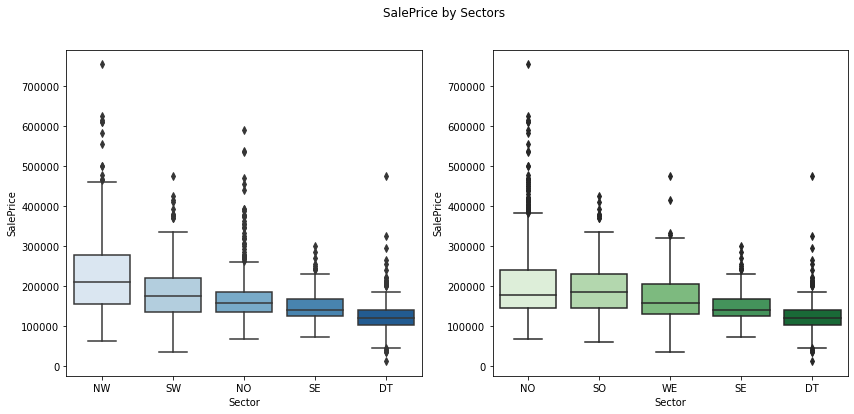

In [32]:
#Set plot size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('SalePrice by Sectors')

sns.boxplot(ax=ax1, x=anal_1['Sector'], y=anal_1['SalePrice'], 
            order=['NW','SW','NO','SE','DT'],
            palette="Blues")
sns.boxplot(ax=ax2, x=anal_2['Sector'], y=anal_2['SalePrice'], 
            order=['NO','SO','WE','SE','DT'],
            palette="Greens")

# Keep Original Sectors? (map_data1)

#### Export to CSV

In [33]:
map_data1.to_csv('sectors.csv')